In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
%matplotlib inline

## The next cell loads data from the John Hopkins github repository on the Corona virus: https://github.com/CSSEGISandData/COVID-19

If you want to run this code, make sure that the paths below are correctly pointing to a copy of the John Hopkins repository.

In [4]:
data_confirmed = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
data_deaths = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
data_recovered = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
data = [data_confirmed, data_deaths, data_recovered]
data_confirmed_orig = data_confirmed.copy()
data_confirmed_orig.fillna('',inplace=True)

In [8]:
mask = data_confirmed_orig.drop(["Lat","Long"], axis = 1).sum(numeric_only=True, axis=1)>100
for d in data:
    d.drop([i for i in range(d.shape[0]) if mask[i]!=True], inplace=True)
    d.loc[d["Province/State"].notna(), "Country/Region"] += ' ' + d.loc[d["Province/State"].notna(), "Province/State"]
    d.drop(["Province/State", "Lat", "Long"] ,axis = 1, inplace=True)
    cols = d.columns
    new_cols = map(lambda x: pd.datetime(*[int(x.split('/')[k]) for k in [2,0,1]]), cols[1:])
    d.set_axis(["Location"] + list(new_cols), axis=1, inplace=True)
    d.set_axis(range(len(d.index)), axis=0, inplace=True)

/home/michalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


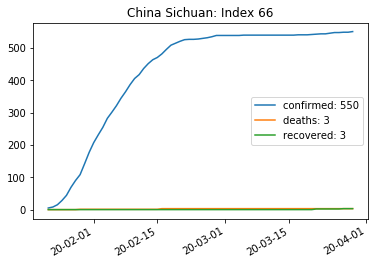

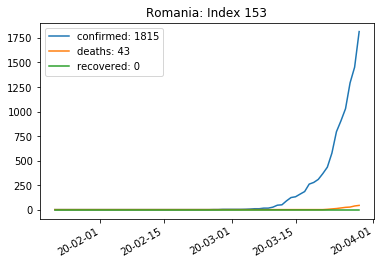

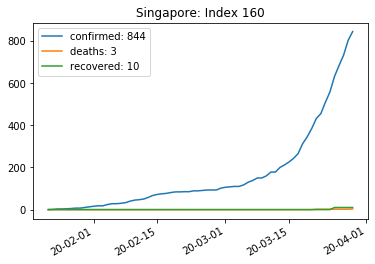

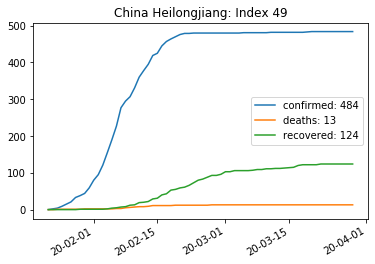

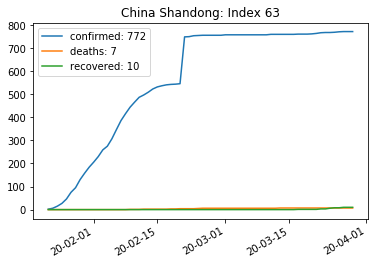

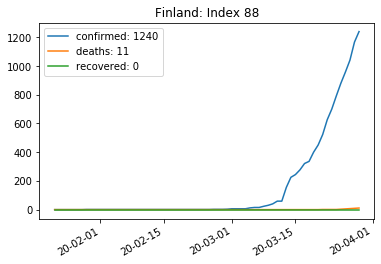

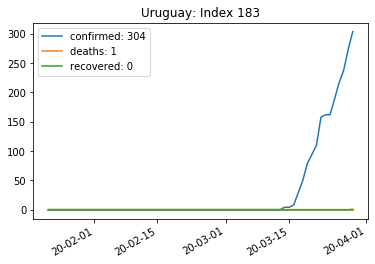

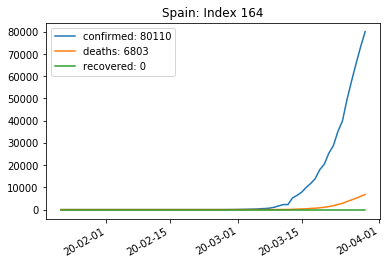

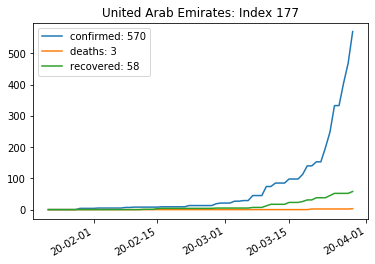

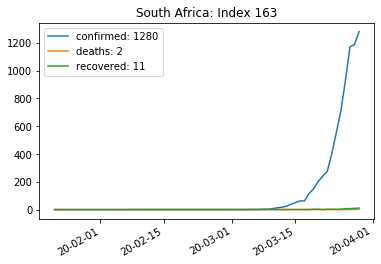

In [18]:
sample_size = 10
sample = random.sample(range(data_confirmed.shape[0]),sample_size)
for index in sample:
    country = data_confirmed.iloc[index][0]
    df = pd.DataFrame([d.iloc[index][1:] for d in data], index=[0,1,2])
    total = df.iloc[:,-1]
    df.set_axis(["confirmed: {}".format(total.loc[0]),"deaths: {}".format(total[1]),"recovered: {}".format(total[2])], inplace=True, axis=0)
    df.transpose().plot(title=country + ': Index {}'.format(index))


In [19]:
L = ["Austria", "Ireland", "Germany", "Italy"]
newest_data = {"Austria": 1332, "Ireland": 223, "Germany":8604, "Italy":27980}

Austria
Reg score 0.9766937802214726
Reg coeff [[0.23028898]]
Intercept [4.11748783]
Prediction for today:  [[15435.47061125]]
Value today:  13    8788.0
Name: 0020-03-29 00:00:00, dtype: float64
Prediction for tomorrow:  [[24465.0633351]]
Ireland
Reg score 0.9798485859316179
Reg coeff [[0.25205376]]
Intercept [2.32592083]
Prediction for today:  [[4338.18372896]]
Value today:  111    2615.0
Name: 0020-03-29 00:00:00, dtype: float64
Prediction for tomorrow:  [[7181.89504973]]
Germany
Reg score 0.9827672294057808
Reg coeff [[0.21142772]]
Intercept [6.38324624]
Prediction for today:  [[94609.33655442]]
Value today:  99    62095.0
Name: 0020-03-29 00:00:00, dtype: float64
Prediction for tomorrow:  [[144403.51958276]]
Italy
Reg score 0.9721498438544777
Reg coeff [[0.13536311]]
Intercept [8.56380179]
Prediction for today:  [[134930.68006367]]
Value today:  113    97689.0
Name: 0020-03-29 00:00:00, dtype: float64
Prediction for tomorrow:  [[176882.80363365]]


/home/michalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/home/michalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/home/michalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/home/michalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/home/michalis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarnin

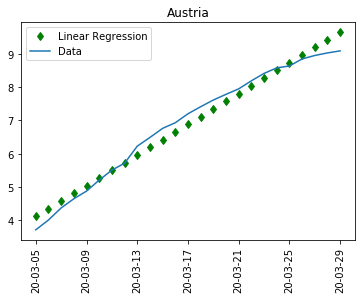

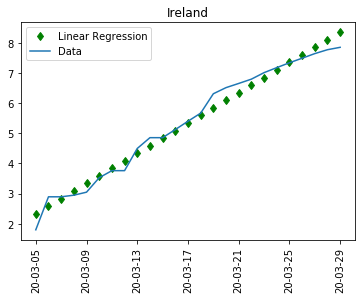

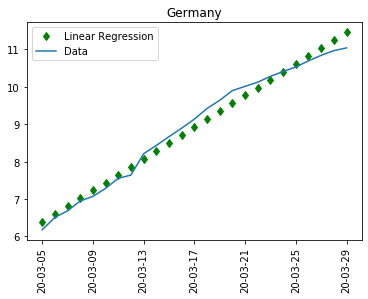

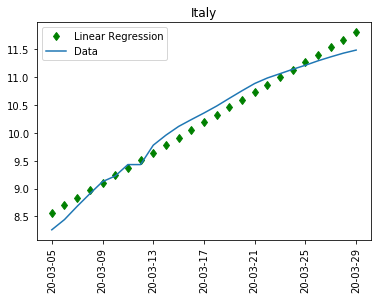

In [22]:
from sklearn.linear_model import LinearRegression
#import statsmodels.formula.api as sm
for country in L:
    y = data_confirmed.loc[data_confirmed["Location"]==country].iloc[:,1:].transpose()
    march1st = y.index.get_loc(pd.datetime(20,3,1))
    y = y.loc[pd.datetime(20,3,5):pd.datetime(20,3,30)]
    y = y[y!=0].dropna().apply(np.log)
    #y = y.append(pd.Series({y.columns[0]:np.log(newest_data[country])}, name=pd.datetime(20,3,17)))
    X = np.array(range(y.shape[0])).reshape(-1,1)
    reg = LinearRegression()
    reg.fit(X,y)
    print(country)
    print('Reg score', reg.score(X, y))
    print('Reg coeff', reg.coef_)
    print('Intercept', reg.intercept_)
    plt.figure()
    plt.plot(y.index,(reg.predict(X)), 'gd', label='Linear Regression')
    plt.plot(y.index, (np.array(y)), label='Data')
    plt.title(country)
    plt.legend(loc="best")
    plt.xticks(rotation='vertical')
    print('Prediction for today: ', np.exp(reg.predict((X[-1]).reshape(-1,1))))
    print('Value today: ', np.exp(y.iloc[-1]))
    print('Prediction for tomorrow: ', np.exp(reg.predict((X[-1]+2).reshape(-1,1))))
    
    #reg.predict(np.array([[3, 5]]))
